# LevanteDP Anemia

In [1]:
from lifelines import CoxPHFitter
from lifelines import CoxTimeVaryingFitter
import matplotlib.pyplot as plt
import pandas as pd

import importPeritoneal as i
import Anemia as a
import hospital as h

## Load Data

In [2]:
#file_path = ['/home/jovyan/work/Data/LevanteDP/LevanteDPC.xls']
file_path = ['/home/jovyan/work/Data/LevanteDP/LevanteDPC.xls', '/home/jovyan/work/Data/LevanteDP/LevanteDPPeset.xlsx']

# Load data from excel file
dfs_base = i.load_excel_files(file_path)
merged_df = i.merge_dataframes(dfs_base['Analíticas'], dfs_base['Pacientes'], 'REGISTRO')

# Save them as pickle for fast loading in testing
merged_df.to_pickle('merged_df.pkl')
dfs_base['Ingresos'].to_pickle('Ingresos.pkl')

In [3]:
# Load the data
merged_df = pd.read_pickle('merged_df.pkl')
dfs_base['Ingresos'] = pd.read_pickle('Ingresos.pkl')

## Preprocesado de datos

In [4]:
# Basic data variables
baseline_cat_cols = ['SEXO', 'CKD_STAGE', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR']
baseline_num_cols = ['EDAD', 'CKD_CALC', 'GLUCOSA', 'UREA', 'CREATININA', 'URICO', 'SODIO', 'POTASIO', 'CALCIO', 'FOSFORO', 'HIERRO', 'TRANSFERRINA', 'IST', 'FERRITINA', 'COLESTEROL', 'TRIGLICERIDOS', 'HDL', 'LDL', 'LEUCOCITOS', 'NEUTROFILOS', 'LINFOCITOS', 'MONOCITOS', 'EOSINOFILOS', 'BASOFILOS', 'GRANULOCITOS', 'HEMATIES', 'HEMOGLOBINA', 'HEMATOCRITO', 'VCM', 'HCM', 'CHCM', 'PLAQUETAS', 'PLAQUETOCRITO', 'VPM']

basic_cols_lab = ['REGISTRO', 'FECHA', 'HEMOGLOBINA', 'INICIO_DP']
basic_cols_hosp = ['REGISTRO', 'FINGRESO']
basic_cols_per = ['REGISTRO', 'FECHA']

bool_col_list = ['CARDIORENAL', 'PASO_A_HD', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'FRAGNOS', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR', 'OTROSFR', 'CIRUGIA']
covariate_list = ['HEMOGLOBINA', 'IST', 'HIERRO']
exclude_list = ['CARDIO']


# Clean NaNs for interesting columns
lab_df = i.clean_df(merged_df, basic_cols_lab, verbose=True)
lab_df = i.clean_df(lab_df, covariate_list, verbose=True)
hosp_df = i.clean_df(dfs_base['Ingresos'], basic_cols_hosp, verbose=True)
per_df = i.clean_df(dfs_base['Peritonitis'], basic_cols_per, verbose=True)

# Select years
lab_df, hosp_df, per_df = i.filter_by_year([lab_df, hosp_df, per_df], ['FECHA', 'FINGRESO', 'FECHA'], 2009, 2024)


# Add anemia column based on 'HEMOGLOBINA' and 'SEXO' specified in KDIGO guidelines
a.add_anemia_column(lab_df)
i.add_age_column(lab_df)
i.add_ckd_column(lab_df)

# Fill empty values for bool_cols
lab_df = i.bool_col_convert(lab_df, bool_col_list)

# Exclude patients with exclude_list
#lab_df = lab_df[lab_df['ICEDAD'] <= 11]
lab_df = i.exclude_patients(lab_df, exclude_list, verbose=True)

# Add days since the start of pd for every column in both dataframes
lab_df = h.add_days_since_start(lab_df, lab_df, 'FECHA')
hosp_df = h.add_days_since_start(lab_df, hosp_df, 'FINGRESO')
per_df = h.add_days_since_start(lab_df, per_df, 'FECHA')


# Now keep only the first year after the patients started PD
lab_df = h.filter_df(lab_df, 'days_since_start', 0, (365), verbose=True)
hosp_df = h.filter_df(hosp_df, 'days_since_start', 0, (365), verbose=True)
per_df = h.filter_df(per_df, 'days_since_start', 0, (365), verbose=True)

# Create the cox_df with all necessary data
cox_df = h.prepare_cox_df(lab_df, hosp_df, covariate_list)
cox_time_varying_df = h.cox_time_varying_prep(lab_df, hosp_df, covariate_list, 365)

cox_df_per = h.prepare_cox_df(lab_df, per_df, covariate_list)

The dataframe had 4747 rows (Unique patients: 470), after the clean up of missing values, it has 4617 rows (Unique patients: 467)
The dataframe had 4617 rows (Unique patients: 467), after the clean up of missing values, it has 4503 rows (Unique patients: 466)
The dataframe had 1028 rows (Unique patients: 472), after the clean up of missing values, it has 561 rows (Unique patients: 271)
The dataframe had 992 rows (Unique patients: 439), after the clean up of missing values, it has 983 rows (Unique patients: 434)
Rows before excluding patients: 4503
Rows after excluding patients: 2477
Percentage of deleted rows: 44.992227403952924%
Rows before filter: 2477 (Unique patients: 274)
Rows after filter: 1158 (Unique patients: 269)
Rows before filter: 185 (Unique patients: 99)
Rows after filter: 68 (Unique patients: 53)
Rows before filter: 202 (Unique patients: 105)
Rows after filter: 91 (Unique patients: 60)


## 6.1 Cox hemoglobina - hospitalización

<lifelines.CoxPHFitter: fitted with 269 total observations, 217 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 269
number of events observed = 52
   partial log-likelihood = -278.23
         time fit was run = 2024-05-19 08:45:37 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.27      0.76      0.12           -0.52           -0.03                0.60                0.97
IST          0.05      1.05      0.02            0.00            0.10                1.00                1.10
HIERRO      -0.03      0.97      0.01           -0.06           -0.01                0.95                0.99

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00 -2.19 0.03      5.14
IST            0.00  2.05 0.04      4.62
HIERRO         0.00 -2.50 0.01      6.33
---
Concordance = 0.64
Partial AIC = 562.46
log-likelihood ratio test = 14.83 on 3 df
-log2(p) of ll-ratio test = 8.99

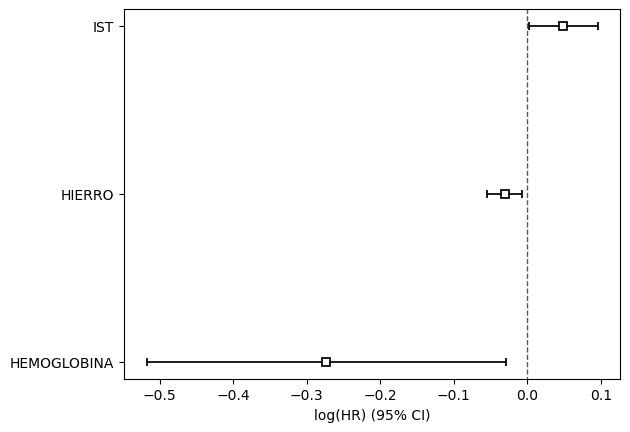

In [5]:
# Initialize the CoxPHFitter

cph_hosp = CoxPHFitter()

# Fit the data to the model
cph_hosp.fit(cox_df, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph_hosp.print_summary()

# Plot the coefficients of the model
cph_hosp.plot()
plt.show()

Martingale Residuals:
      finish_days  event_col  martingale
211          3.0       True    0.994364
58           4.0       True    0.982520
62           7.0       True    0.986334
187         11.0       True    0.985748
220         12.0       True    0.903617
..           ...        ...         ...
264        365.0      False   -0.625428
265        365.0      False   -0.199553
266        365.0      False   -0.140990
267        365.0      False   -0.392587
268        365.0      False   -0.113104

[269 rows x 3 columns]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.
Schonenfeld Residuals:
 [[<Axes: xlabel='rank-transformed time\n(p=0.7584)'>, <Axes: xlabel='km-transformed time\n(p=0.7493)'>], [<Axes: xlabel='rank-transformed time\n(p=0.1015)'>, <Axes: xlabel='km-transformed time\n(p=0.1022)'>], [<Axes: xlabel='rank-transformed ti

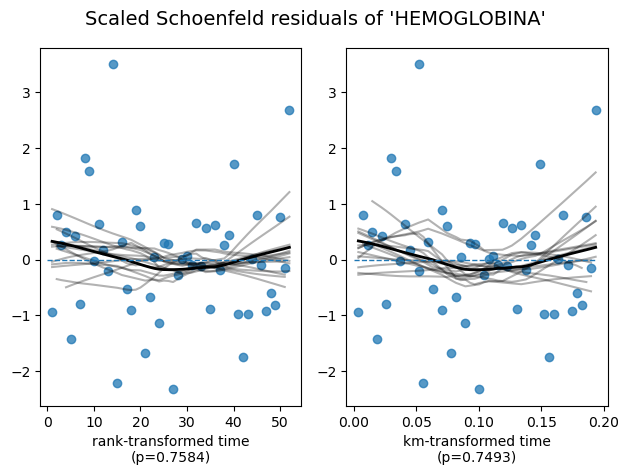

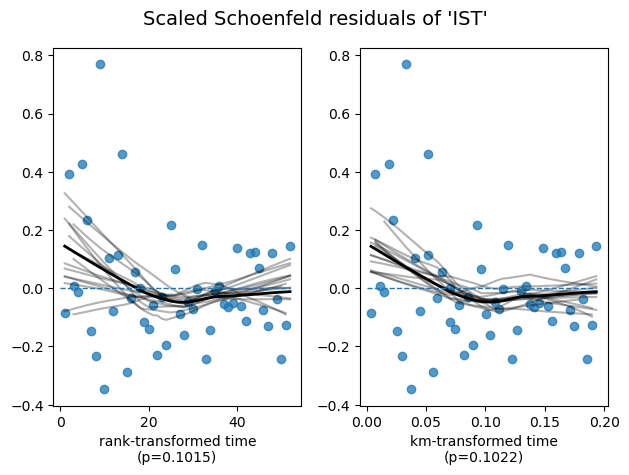

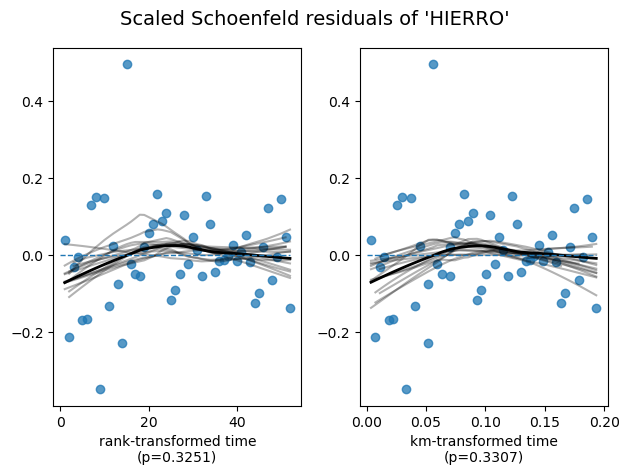

In [8]:
a.calculate_residuals(cph, cox_df, martingale=True, schonenfeld=True)

## 6.3 Cox hemoglobina - peritonitis

<lifelines.CoxPHFitter: fitted with 269 total observations, 209 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 269
number of events observed = 60
   partial log-likelihood = -325.06
         time fit was run = 2024-05-19 08:57:12 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA  0.01      1.01      0.11           -0.20            0.22                0.82                1.25
IST          0.05      1.05      0.02            0.01            0.09                1.01                1.10
HIERRO      -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00  0.08 0.93      0.10
IST            0.00  2.58 0.01      6.65
HIERRO         0.00 -2.55 0.01      6.52
---
Concordance = 0.58
Partial AIC = 656.11
log-likelihood ratio test = 7.00 on 3 df
-log2(p) of ll-ratio test = 3.80

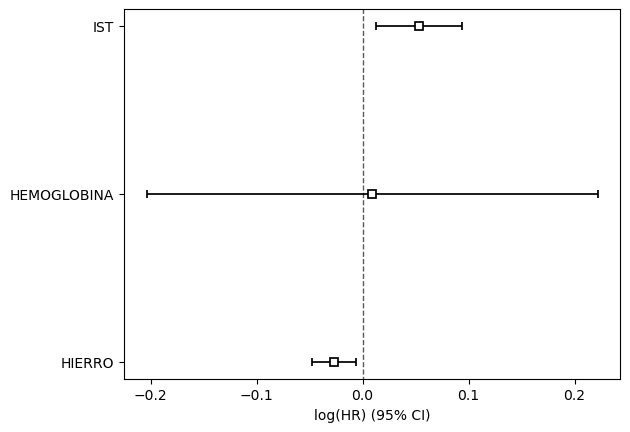

In [9]:
# Initialize the CoxPHFitter

cph_per = CoxPHFitter()

# Fit the data to the model
cph_per.fit(cox_df_per, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph_per.print_summary()

# Plot the coefficients of the model
cph_per.plot()
plt.show()

Martingale Residuals:
      finish_days  event_col  martingale
267          5.0       True    0.995317
64          13.0       True    0.993496
112         19.0       True    0.986253
59          20.0       True    0.983429
264         34.0       True    0.979082
..           ...        ...         ...
260        365.0      False   -0.561463
261        365.0      False   -0.202926
263        365.0      False   -0.389810
265        365.0      False   -0.322584
268        365.0      False   -0.143908

[269 rows x 3 columns]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.
Schonenfeld Residuals:
 [[<Axes: xlabel='rank-transformed time\n(p=0.2666)'>, <Axes: xlabel='km-transformed time\n(p=0.2591)'>], [<Axes: xlabel='rank-transformed time\n(p=0.1169)'>, <Axes: xlabel='km-transformed time\n(p=0.1177)'>], [<Axes: xlabel='rank-transformed ti

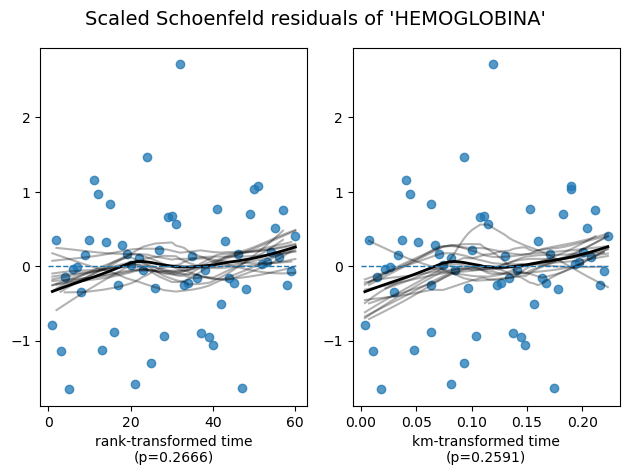

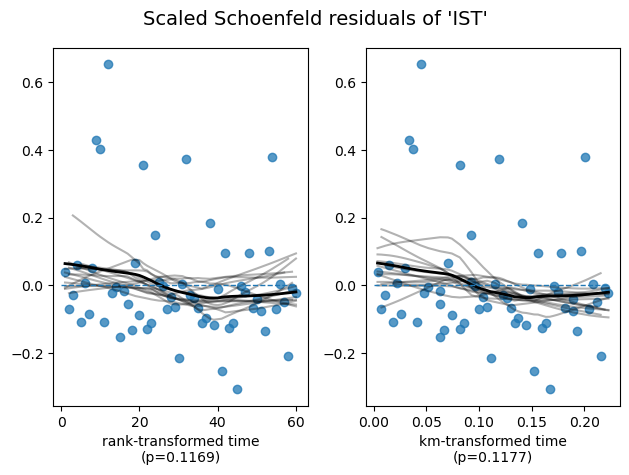

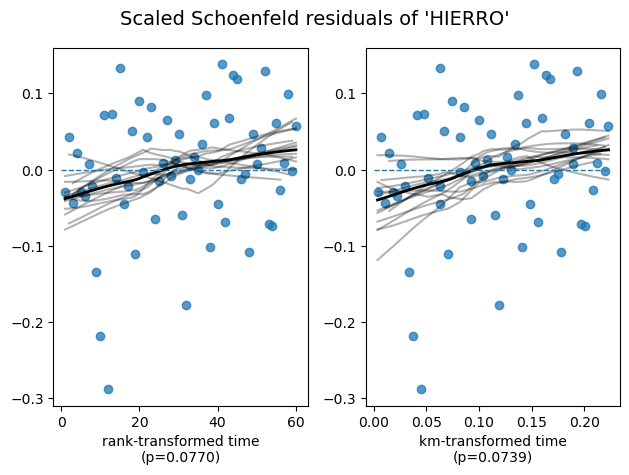

In [10]:
a.calculate_residuals(cph_per, cox_df_per, martingale=True, schonenfeld=True)

## Prevalencia de anemia en pacientes con ERC en DP

In [ ]:
# Reload the full dataframe without filtering

anemia_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA', 'REGISTRO', 'FECHA']
merged_df = pd.read_pickle('merged_df.pkl')
anemia_df = i.clean_df(merged_df, anemia_cols, verbose=True)
a.add_anemia_column(anemia_df)
anemia_df = i.filter_by_year([anemia_df], ['FECHA'], 2009, 2023)[0]
anemia_prevalence = a.anemia_prevalence(anemia_df, print_results=True, print_graph=True, tendency=True)

## Tendencias marcadores de anemia

In [ ]:
time_trend_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA']
time_trend_df = a.time_trend_analysis(anemia_df, 1, time_trend_cols, 365, plot_results=True)

In [ ]:
p_values_test = a.t_test_first_last(time_trend_df, print_results=True)

In [ ]:
a.stationary_test(time_trend_df, col_str='_avg')

In [ ]:
print(time_trend_df)

## Baseline

In [ ]:
baseline = i.calculate_baseline(lab_df, baseline_cat_cols, baseline_num_cols)
i.print_baseline(baseline)

In [ ]:
'''
Introducción anemia ferropénica (unas 10-20 paginas) en CKD
    Enf renal crónica general -> complicaciones 
    Anemia: importancia, prevalencia, impacto pronóstico...

Hipotesis de trabajo
    Anemia tiene inpacto pronóstico en paciente peritoneal con hospitalizaciones
Definir bien objetivos
    Claros y definidos
    Prevalencia, incidencia, variabilidad y su impacto en hospitalización
    Impacto pronóstico de la anemia en hospitalización y factores de riesgo 
Material y métodos (mitar el TFG dislipemia)
    Registro Levante
Resultados
    Seguir el orden de los objetivos
        Prevalencia
        Incidencia
        Impacto...
Discusión
    Primer párrafo: hallazgo del estudio
    Segundo párrafo: incidencia con otros datos y artículos
    Limitaciones
    Conclusiones: respuesta a objetivos




Contemplar meter variabilidad de Hb y modelos predictivos. Factores predictores de la Hb.


'''
